In [1]:
from glob import glob
import scipy.misc
import pandas as pd
%matplotlib inline
import os, errno
from pathlib import PurePath
import skimage.transform
import matplotlib.pyplot as plt
import shutil
import numpy as np
from tqdm import tqdm

from keras.preprocessing.image import ImageDataGenerator


Using TensorFlow backend.
C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
X_train_files = glob('stage1_train/**/images/*.png')

In [3]:
sizes = []
for file in (X_train_files):
    imgg = scipy.misc.imread(file)
    sizes.append(imgg.shape)

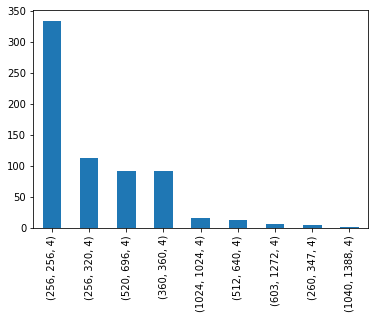

In [19]:
pd.Series(sizes).value_counts().plot(kind = 'bar')

In [20]:
#Lets resize all the images to (256,256,4) once, this will greatly speed up 
#training when using a generator.

image_shape = (256,256)

for path in  tqdm(glob('stage1_train/**/images/*.png', recursive=True)):
    path_parts = PurePath(path).parts
    directory = os.path.join('resized_train',*path_parts[1:-2])
    file_name = os.path.basename(path)
    try:
        os.makedirs(directory)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise
           
    imgg = skimage.transform.resize(scipy.misc.imread(path) , image_shape, mode='constant' , preserve_range=True)
    
    scipy.misc.imsave(os.path.join(directory, file_name),imgg[:,:,:4])

100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [00:35<00:00, 22.15it/s]


In [21]:
#lets combine the masks into one image and resize that image

image_shape = (256,256)

for mask_paths in  tqdm(glob('stage1_train/**/masks', recursive=True)):
    mask_files = os.path.join(mask_paths,'*.png')
    #get the size of the current mask to create an empty numpy array
    first_mask_size = scipy.misc.imread(glob(mask_files)[0]).shape
    mask = np.zeros(first_mask_size)
    for mask_path in glob(mask_files):
        
        mask_ = scipy.misc.imread(mask_path)
        np.maximum(mask, mask_, out=mask)
       
    path_parts = PurePath(mask_paths).parts
    directory = os.path.join('resized_train',*path_parts[1:-1], )
    file_name = path_parts[1]+'_mask.png'
    try:
        os.makedirs(directory)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise
            
    mask = skimage.transform.resize(mask, image_shape, mode='constant' , preserve_range=True)        
    scipy.misc.imsave(os.path.join(directory, file_name),mask)

100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [00:45<00:00, 26.41it/s]


In [8]:
#lets split our data in to train and validation sets
try:
    shutil.rmtree('train/')
    shutil.rmtree('valid/')
except:
    pass

for typee in ['train','valid']:
    os.makedirs(os.path.join(typee,'masks','masks'))
    os.makedirs(os.path.join(typee,'images','images'))

for mask_file in glob('resized_train/**/*_mask.png', recursive=True):
    #for file in glob(s+'/*.png'):
    image_file = mask_file.replace('_mask','')
    if np.random.rand(1)[0] < 0.8:
        shutil.copy(mask_file, dst=os.path.join('train','masks','masks',os.path.basename(mask_file)))
        shutil.copy(image_file, dst=os.path.join('train','images','images',os.path.basename(image_file)))

    else:
        shutil.copy(mask_file, dst=os.path.join('valid','masks','masks',os.path.basename(mask_file)))
        shutil.copy(image_file, dst=os.path.join('valid','images','images',os.path.basename(image_file)))


In [9]:
data_gen = ImageDataGenerator(rescale = 1./255)
img_height = 256
img_width = 256


In [23]:
# For training data
seed_val = 76534 # so both input and labels are synced
train_data_gen = data_gen.flow_from_directory('train/images/',
batch_size = 32, seed=9987, class_mode= None)

train_mask_gen = data_gen.flow_from_directory('train/masks/',
batch_size = 32, seed=9987, class_mode= None)

Found 522 images belonging to 1 classes.
Found 522 images belonging to 1 classes.


In [24]:
# For validation data
seed_val = 432114 # so both input and labels are synced
val_data_gen = data_gen.flow_from_directory('valid/images/',
batch_size = 32, seed=33224, class_mode= None)

val_mask_gen = data_gen.flow_from_directory('valid/masks/',
batch_size = 32, seed=33224, class_mode= None)

Found 148 images belonging to 1 classes.
Found 148 images belonging to 1 classes.


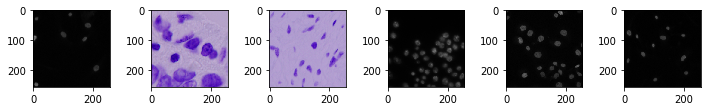

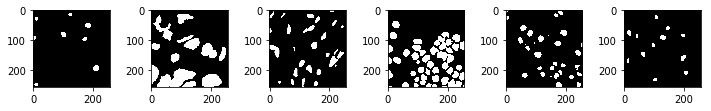

In [25]:
#Lets explore some outputs from generators
samples_images = next(train_data_gen)
samples_masks = next(train_mask_gen)

f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(10, 10))
f.tight_layout()
ax1.imshow(samples_images[0])
ax2.imshow(samples_images[5])
ax3.imshow(samples_images[10])
ax4.imshow(samples_images[15])
ax5.imshow(samples_images[20])
ax6.imshow(samples_images[25])

f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(10, 10))
f.tight_layout()
ax1.imshow(samples_masks[0])
ax2.imshow(samples_masks[5])
ax3.imshow(samples_masks[10])
ax4.imshow(samples_masks[15])
ax5.imshow(samples_masks[20])
ax6.imshow(samples_masks[25])